In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

In [28]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0
**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Zdobycie danych

In [29]:
DATA_PATH = os.path.abspath(os.path.join('..', 'data', 'processed', 'ravdess'))

In [30]:
NUMBER_LANDMARKS = 100
LANDMARK_INDEXES = np.load(os.path.join('..', 'data', 'landmarks', f'top_{NUMBER_LANDMARKS}_important_landmarks.npy'))

### Wizualizacja wybranych punktów

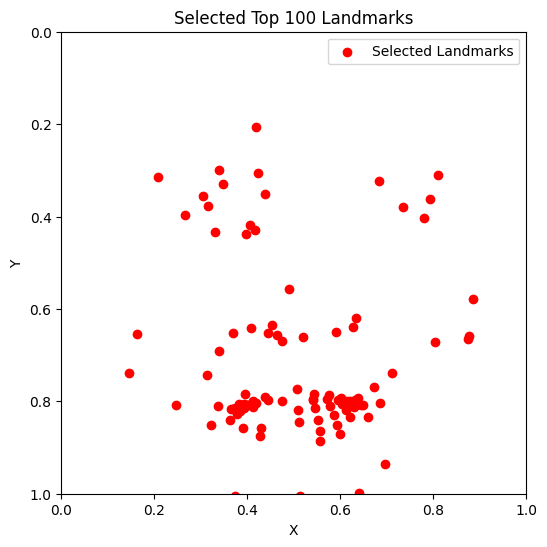

In [31]:
loaded_key_points = np.load(os.path.join('..', 'data', 'reference_points', 'key_points_xyz.npy'))
selected_key_points = loaded_key_points[:, LANDMARK_INDEXES, :]

# Plot the key points
plt.figure(figsize=(6, 6))
plt.scatter(selected_key_points[:, :, 0], selected_key_points[:, :, 1], c='r', marker='o', label='Selected Landmarks')

# Flip Y-axis if needed (often in image coordinates)
plt.gca().invert_yaxis()

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Selected Top {NUMBER_LANDMARKS} Landmarks")
plt.legend()
plt.xlim(0, 1)
plt.ylim(1, 0)
plt.show()


In [7]:
def load_data(data_path):
    all_data = []
    all_labels = []

    for file in os.listdir(data_path):
        if file.endswith(".npy"):
            data = np.load(os.path.join(data_path, file), allow_pickle=True)
            data = np.array(data, dtype=np.float32)
            selected_data = data[:, LANDMARK_INDEXES, :]

            all_data.append(selected_data)

            label = int(file.split("-")[2])
            all_labels.append(label)

    return np.array(all_data, dtype=object), np.array(all_labels)

In [8]:
all_data, all_labels = load_data(DATA_PATH)

## Preprocessing danych

In [12]:
def preprocess_data(data, labels):
    tensor_data = [torch.tensor(d, dtype=torch.float32) for d in data]
    padded_data = pad_sequence(tensor_data, batch_first=True)

    encoder = LabelBinarizer()
    encoded_labels = encoder.fit_transform(labels)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)

    X_train, X_temp, y_train, y_temp = train_test_split(
        padded_data, encoded_labels, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels)

In [11]:
print(X_train.shape)
print(y_train.shape)

torch.Size([2012, 157, 100, 2])
torch.Size([2012, 8])


# MODEL TORCH

### W podejściu wykorzystane zostaną 2 modele - pierwszy z nich będzie siecią konwolucyjną 2d, która będzie miała za zadanie nauczyć się rozpoznawać cechy charakterystyczne dla wybranej klatki (zbioru współrzędnych pkt charakterystycznych). Do klasyfikacji szeregu czasowego zostanie wykorzystana sekwencyjna sieć neuronowa LSTM.

## Zbudowanie modelu ekstrakcji cech

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self, number_landmarks=NUMBER_LANDMARKS):
        super(EmotionClassifier, self).__init__()
        self.number_landmarks = number_landmarks
        
        # Spatial feature extraction using Conv1D
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the number of features after Conv1D and pooling
        # Conv1D output: (batch_size * frames, 32, number_landmarks)
        # Pool1D output: (batch_size * frames, 32, number_landmarks // 2)
        self.flattened_features = 32 * (number_landmarks // 2)
        
        # LSTM layers for temporal feature extraction
        self.lstm1 = nn.LSTM(input_size=self.flattened_features, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128 * 2, hidden_size=64, batch_first=True)
        
        # Fully connected classification layer
        self.fc = nn.Linear(64, 8)  # 8 emotion classes

    def forward(self, x):
        # x shape: (batch_size, frames, number_landmarks, 2)
        batch_size, frames, landmarks, coordinates = x.shape
        
        # Reshape for Conv1D: (batch_size * frames, coordinates, landmarks)
        x = x.view(-1, landmarks, coordinates).permute(0, 2, 1)  # Shape: (batch_size * frames, 2, number_landmarks)
        
        # Spatial feature extraction
        x = F.relu(self.conv1(x))  # Shape: (batch_size * frames, 32, number_landmarks)
        x = self.pool1(x)          # Shape: (batch_size * frames, 32, number_landmarks // 2)
        
        # Flatten spatial features
        x = x.view(batch_size, frames, -1)  # Shape: (batch_size, frames, 32 * (number_landmarks // 2))
        
        # Temporal feature extraction
        x, _ = self.lstm1(x)  # Shape: (batch_size, frames, 128 * 2)
        x, _ = self.lstm2(x)  # Shape: (batch_size, frames, 64)
        
        # Classification
        x = self.fc(x[:, -1, :])  # Take the last timestep's output; Shape: (batch_size, 8)
        return x


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

## Trening modelu

In [23]:
BATCH_SIZE = 32
EPOCHS = 300

In [24]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
writer = SummaryWriter("runs/torch-lstm/emotion_classifier_optimized_landmarks")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.argmax(dim=1)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)
    
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.argmax(dim=1)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(y_batch).sum().item()
            total += y_batch.size(0)
    
    val_acc = correct / total

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)

    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
writer.close()


Epoch 1/300, Train Loss: 130.4423, Train Acc: 0.1238, Val Loss: 28.8964, Val Acc: 0.1276
Epoch 2/300, Train Loss: 130.1587, Train Acc: 0.1272, Val Loss: 28.8733, Val Acc: 0.1276
Epoch 3/300, Train Loss: 130.0699, Train Acc: 0.1302, Val Loss: 28.8711, Val Acc: 0.1323
Epoch 4/300, Train Loss: 130.1428, Train Acc: 0.1218, Val Loss: 28.8703, Val Acc: 0.1299
Epoch 5/300, Train Loss: 130.0132, Train Acc: 0.1317, Val Loss: 28.8641, Val Acc: 0.1276
Epoch 6/300, Train Loss: 130.0402, Train Acc: 0.1307, Val Loss: 28.8609, Val Acc: 0.1323
Epoch 7/300, Train Loss: 130.0745, Train Acc: 0.1252, Val Loss: 28.8705, Val Acc: 0.1276
Epoch 8/300, Train Loss: 130.0503, Train Acc: 0.1312, Val Loss: 28.8609, Val Acc: 0.1415
Epoch 9/300, Train Loss: 130.0555, Train Acc: 0.1282, Val Loss: 28.8563, Val Acc: 0.1439
Epoch 10/300, Train Loss: 130.0160, Train Acc: 0.1352, Val Loss: 28.8547, Val Acc: 0.1531
Epoch 11/300, Train Loss: 130.0345, Train Acc: 0.1337, Val Loss: 28.8538, Val Acc: 0.1555
Epoch 12/300, Train

## Ewaluacja modelu

In [26]:
model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_batch = y_batch.argmax(dim=1)
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)

test_loss /= len(y_test)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0395, Test Accuracy: 0.5486
